In [1]:
# install appropriate dependencies

# need numpy 1 to stop numpy dtype size changed error
!pip install "pmdarima[all]" "numpy==1.26.4"

In [2]:
# import required packages
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pmdarima.arima import auto_arima
import tensorflow as tf

# 1) Lock down hashing & TF ops
os.environ['PYTHONHASHSEED']   = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# 2) Seed each RNG
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# import google drive packages
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls /content/drive/MyDrive/Career/Data_Masters_Challenge/

 cleaned_electricity.csv		        Final_cleaned_data.csv
'Data Masters Challenge Business Report.gdoc'   team7_models_2.ipynb
'Data Masters Challenge Work Doc.gdoc'	        TempCodebase.ipynb
 electricity.csv


In [ ]:
# reading data
import pandas as pd
csv_path = '/content/drive/MyDrive/Career/Data_Masters_Challenge/cleaned_electricity.csv'
dat = pd.read_csv(csv_path)

# Quick check
# df.head()

In [6]:
# #dat = pd.read_csv("https://media.githubusercontent.com/media/buds-lab/building-data-genome-project-2/refs/heads/master/data/meters/raw/electricity.csv")
# dat = pd.read_csv("Final_cleaned_data.csv")

# dat = dat[dat.columns.difference(["timestamp","month","year","total_energy","z_score"])] # OLD

# take out irrelevant columns for modeling
dat = dat[dat.columns.difference(["timestamp","month","year","total_energy","z_score","is_anomaly"])] # NEW

In [7]:
# view dataset
dat

,Bear_assembly_Angel,Bear_assembly_Beatrice,Bear_assembly_Diana,Bear_assembly_Genia,Bear_assembly_Jose,Bear_assembly_Roxy,Bear_assembly_Ruby,Bear_education_Alfredo,Bear_education_Alvaro,Bear_education_Arnold,...,Wolf_office_Emanuel,Wolf_office_Haydee,Wolf_office_Joana,Wolf_office_Nadia,Wolf_office_Rochelle,Wolf_public_Norma,Wolf_retail_Harriett,Wolf_retail_Marcella,Wolf_retail_Toshia,Wolf_science_Alfreda
0,237.8500,9.00,1.148,178.7858,148.50,9.75,51.50,0.1025,358.4388,0.519,...,13.3400,4.9100,14.6900,50.9975,8.8600,72.8408,22.7300,9.8575,17.6575,87.6400
1,221.2500,10.25,1.148,184.0738,152.00,9.75,52.75,0.0950,355.8990,0.521,...,13.7975,5.1200,14.2425,49.9775,8.9625,67.0392,22.0200,9.6150,18.5775,87.1525
2,222.5000,10.00,1.148,184.9768,153.25,10.00,51.25,0.1025,328.1848,0.590,...,13.3550,4.7325,14.8850,49.3350,8.8200,72.3000,22.1100,9.4900,18.1275,86.9800
3,221.4000,9.00,1.148,184.6900,145.50,9.75,51.00,0.1025,326.3410,0.539,...,13.4625,6.6975,15.3775,50.6450,8.7475,74.5700,21.5050,9.6125,17.4000,87.1375
4,224.2500,10.00,1.148,187.0248,158.25,10.00,51.50,0.1175,325.4633,0.532,...,13.2375,7.0000,15.3375,50.9975,8.4475,71.1233,21.6750,9.4300,17.3875,86.6425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17517,319.2544,67.25,0.485,403.5352,226.50,7.00,68.75,0.1350,371.8235,0.674,...,10.1650,4.7800,15.3300,57.1650,7.2850,56.5333,27.8675,5.4975,18.1000,72.4275
17518,313.7506,66.25,0.429,396.6962,223.00,6.50,68.75,0.1300,371.2127,0.694,...,10.1250,4.7750,15.1600,56.0575,7.3775,63.7867,28.2650,5.2050,18.5750,73.4875
17519,309.0006,67.75,0.503,305.9935,163.50,6.25,68.00,0.1300,375.0352,0.665,...,10.1675,4.7925,14.8750,62.7975,7.1525,63.0400,28.2425,5.4175,19.0250,72.7675
17520,284.5062,41.00,0.424,195.5648,134.25,6.50,68.50,0.1325,371.4132,0.651,...,9.7475,4.5150,14.4775,54.6325,7.1075,62.6133,27.7850,5.0675,18.2100,72.5375


In [8]:
# EDA on data columns
n_obs = dat.shape[0]
dat.describe()

,Bear_assembly_Angel,Bear_assembly_Beatrice,Bear_assembly_Diana,Bear_assembly_Genia,Bear_assembly_Jose,Bear_assembly_Roxy,Bear_assembly_Ruby,Bear_education_Alfredo,Bear_education_Alvaro,Bear_education_Arnold,...,Wolf_office_Emanuel,Wolf_office_Haydee,Wolf_office_Joana,Wolf_office_Nadia,Wolf_office_Rochelle,Wolf_public_Norma,Wolf_retail_Harriett,Wolf_retail_Marcella,Wolf_retail_Toshia,Wolf_science_Alfreda
count,17522.000000,17522.000000,17522.000000,17522.000000,17522.000000,17522.000000,17522.000000,17522.000000,17522.000000,17522.000000,...,17522.000000,17522.000000,17522.000000,17522.000000,17522.000000,17522.000000,17522.000000,17522.000000,17522.000000,17522.000000
mean,476.679703,42.944489,0.894875,263.293742,257.241995,17.080773,69.356659,0.181286,419.656757,0.558994,...,15.081831,8.626523,14.815788,74.248859,16.077133,146.559584,43.702334,7.002205,70.893180,81.415206
std,167.623822,15.610472,0.345937,83.127254,72.219683,13.478723,13.240294,0.090476,61.844445,0.363623,...,6.285490,5.943523,4.982215,22.476497,8.903942,73.023355,19.960541,3.235558,50.605333,11.897054
min,36.500000,1.750000,0.000000,151.320800,126.000000,0.000000,34.750000,0.050000,219.976000,0.000000,...,0.000000,0.000000,0.000000,28.155000,0.000000,17.325000,0.000000,0.002500,7.285000,0.000000
25%,333.250075,34.250000,0.613000,205.980900,194.250000,9.250000,60.500000,0.117500,373.594475,0.363000,...,11.180000,4.410000,11.886250,57.481250,9.005000,79.401675,27.737500,4.697500,30.342500,73.342500
50%,469.545953,37.500000,0.734000,235.312750,249.000000,12.000000,68.250000,0.157500,418.574700,0.464000,...,13.267500,6.345000,14.887500,63.441250,12.277500,135.229550,39.858750,6.122500,39.860000,78.605000
75%,608.750000,55.000000,1.148000,287.045000,313.500000,19.000000,78.250000,0.217500,465.151750,0.545000,...,18.936875,10.890000,17.346875,93.616875,22.691250,205.830850,57.937500,8.625000,119.115625,88.070000
max,1105.600000,83.000000,2.514000,613.510000,533.250000,75.398000,118.000000,0.630000,600.598800,2.427000,...,45.545000,38.472500,30.580000,162.755000,45.350000,330.001700,130.637500,22.645000,206.440000,124.375000


In [9]:
# observe maximum values
maxes = np.array(dat.describe()[7:])
# return the top 10 highest max values
np.sort(maxes[np.isnan(maxes) == False])[-10:]

array([ 8894.   , 10295.   , 10725.   , 11019.   , 11624.   , 12576.   ,
       19401.   , 21579.   , 31921.   , 44336.461])

In [10]:
# check whether there are any missing values
np.argwhere(np.isnan(maxes))

array([], shape=(0, 2), dtype=int64)

In [11]:
# find the entry where maxes is kargest
np.argmax(maxes[~np.isnan(maxes)])

787

In [12]:
maxes[0,787]

44336.461

In [13]:
# print outliers
for outlier in np.sort(maxes[np.isnan(maxes) == False])[-5:]:
  print(np.argwhere(dat.describe() == outlier))

[[  7 218]]
[[  7 154]]
[[  7 164]]
[[  7 156]]
[[  7 787]]


In [14]:
dat.describe()[dat.columns[161]]

,Bull_education_Gregory
count,17522.000000
mean,71.487644
std,23.687490
min,0.000000
25%,55.000000
50%,65.000000
75%,88.000000
max,381.000000


In [15]:
# build a dictionary of sub_df based on partition the feature column

# partition based on building type
names = [name.split("_") for name in dat.columns]
lens = np.array([len(name) for name in names])

sub_dfs = dict([])

for use in ["lodging","education","office","assembly","other","retail","parking","public","warehouse","food","religion","health","utility","science","industrial","services"]:
  print(use)
  use_inds = np.argwhere(np.array([name[1] == use for name in names])).flatten()
  sub_dfs[use] = dat[dat.columns[use_inds]]

lodging
education
office
assembly
other
retail
parking
public
warehouse
food
religion
health
utility
science
industrial
services


In [16]:
# partition based on building location
for building in set([name[0] for name in names]):
  print(building)
  building_inds = np.argwhere(np.array([name[0] == building for name in names])).flatten()
  sub_dfs[building] = dat[dat.columns[building_inds]]

Eagle
Rat
Bobcat
Lamb
Panther
Bear
Moose
Bull
Peacock
Hog
Robin
Shrew
Wolf
Mouse
Fox
Crow
Gator
Cockatoo


In [17]:
sub_dfs["Panther"]

,Panther_assembly_Carrol,Panther_assembly_David,Panther_assembly_Denice,Panther_assembly_Gwyneth,Panther_assembly_Pamella,Panther_education_Alecia,Panther_education_Annetta,Panther_education_Aurora,Panther_education_Cleopatra,Panther_education_Diann,...,Panther_parking_Jody,Panther_parking_Lorriane,Panther_parking_Mellissa,Panther_parking_Stanley,Panther_retail_Felix,Panther_retail_Gilbert,Panther_retail_Kristina,Panther_retail_Lester,Panther_retail_Rachel,Panther_retail_Romeo
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,15.6030,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,15.7230,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.0831,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,15.7230,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,15.7230,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17517,11.3022,43.0083,624.3205,236.2456,129.0249,160.0309,79.2153,68.0131,11.2422,32.1062,...,44.2485,15.4830,18.8036,57.7111,67.0199,0.6401,17.9975,4.7189,1.7203,401.8495
17518,16.4032,38.6074,585.8131,237.8459,129.2249,142.0274,91.2176,67.8131,11.2022,32.7063,...,44.1685,12.7224,18.4035,57.4111,56.6869,0.7301,18.7866,4.7149,1.4403,404.1720
17519,12.6024,38.2074,570.8102,203.8393,129.6250,148.0286,89.2172,69.0133,11.2822,34.8067,...,44.0085,11.2822,18.2435,57.3111,55.0576,0.7201,18.4526,4.7029,2.0004,406.7715
17520,11.6022,36.0069,490.6947,182.4352,128.4248,156.0301,87.1168,67.8131,11.1622,34.9067,...,44.0885,16.9233,20.4840,57.6111,49.6776,0.7201,18.2605,4.6339,1.7203,403.3688


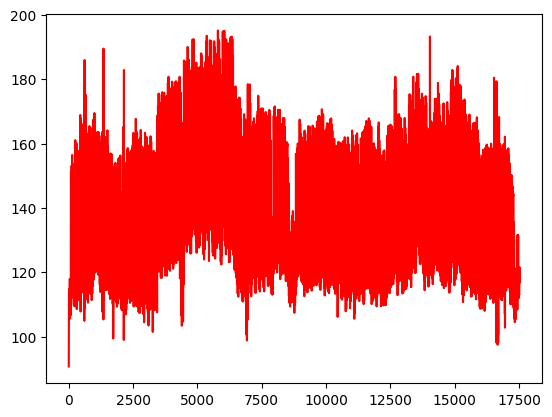

In [18]:
# plot test series

avg_series = dat[dat.columns.difference([dat.columns[i] for i in [153,161,773]])].mean(axis=1)
plt.plot(avg_series, "-r")

# Modelling: Gated Recurrent Units (GRU)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Building 'food': best units=10, val MSE=0.0032
Epoch 1/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - loss: 0.0070
Epoch 2/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - loss: 0.0041
Epoch 3/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - loss: 0.0040
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Building 'parking': best units=25, val MSE=0.0018
Epoch 1/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 0.0030
Epoch 2/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 0.0015
Epoch 3/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - loss: 0.0015
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Building 'public': best units=10, val MSE=0.0009
Epoch 1/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - loss: 0.0067
Epoch 2/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 7.3530e-04
Epoch 3/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 7.1439e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Building 'education': best units=10, val MSE=0.0006
Epoch 1/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - loss: 0.0037
Epoch 2/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 0.0014
Epoch 3/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - loss: 0.0013
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Building 'lodging': best units=25, val MSE=0.0011
Epoch 1/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 0.0023
Epoch 2/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 9.2001e-04
Epoch 3/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 7.9608e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Building 'religion': best units=25, val MSE=0.0067
Epoch 1/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 0.0091
Epoch 2/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - loss: 0.0078
Epoch 3/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 0.0077
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Building 'services': best units=10, val MSE=0.0002
Epoch 1/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - loss: 0.0015
Epoch 2/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - loss: 3.8758e-04
Epoch 3/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 3.7971e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Building 'retail': best units=25, val MSE=0.0005
Epoch 1/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 0.0036
Epoch 2/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 0.0011
Epoch 3/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 0.0011
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Building 'health': best units=25, val MSE=0.0010
Epoch 1/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - loss: 0.0054
Epoch 2/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 0.0013
Epoch 3/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 0.0013
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Building 'other': best units=10, val MSE=0.0051
Epoch 1/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 0.0035
Epoch 2/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 0.0031
Epoch 3/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - loss: 0.0030
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Building 'warehouse': best units=10, val MSE=0.0011
Epoch 1/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 0.0052
Epoch 2/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 0.0014
Epoch 3/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - loss: 0.0013
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Building 'assembly': best units=10, val MSE=0.0006
Epoch 1/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 0.0023
Epoch 2/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 9.9074e-04
Epoch 3/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 8.7570e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Building 'office': best units=10, val MSE=0.0002
Epoch 1/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 0.0054
Epoch 2/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 5.8756e-04
Epoch 3/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - loss: 5.7087e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Building 'industrial': best units=25, val MSE=0.0054
Epoch 1/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 0.0114
Epoch 2/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 0.0071
Epoch 3/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - loss: 0.0069
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Building 'science': best units=25, val MSE=0.0006
Epoch 1/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - loss: 0.0104
Epoch 2/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - loss: 0.0079
Epoch 3/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 0.0074
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Building 'utility': best units=25, val MSE=0.0103
Epoch 1/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - loss: 0.0081
Epoch 2/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 0.0066
Epoch 3/3
15759/15759 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - loss: 0.0065
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


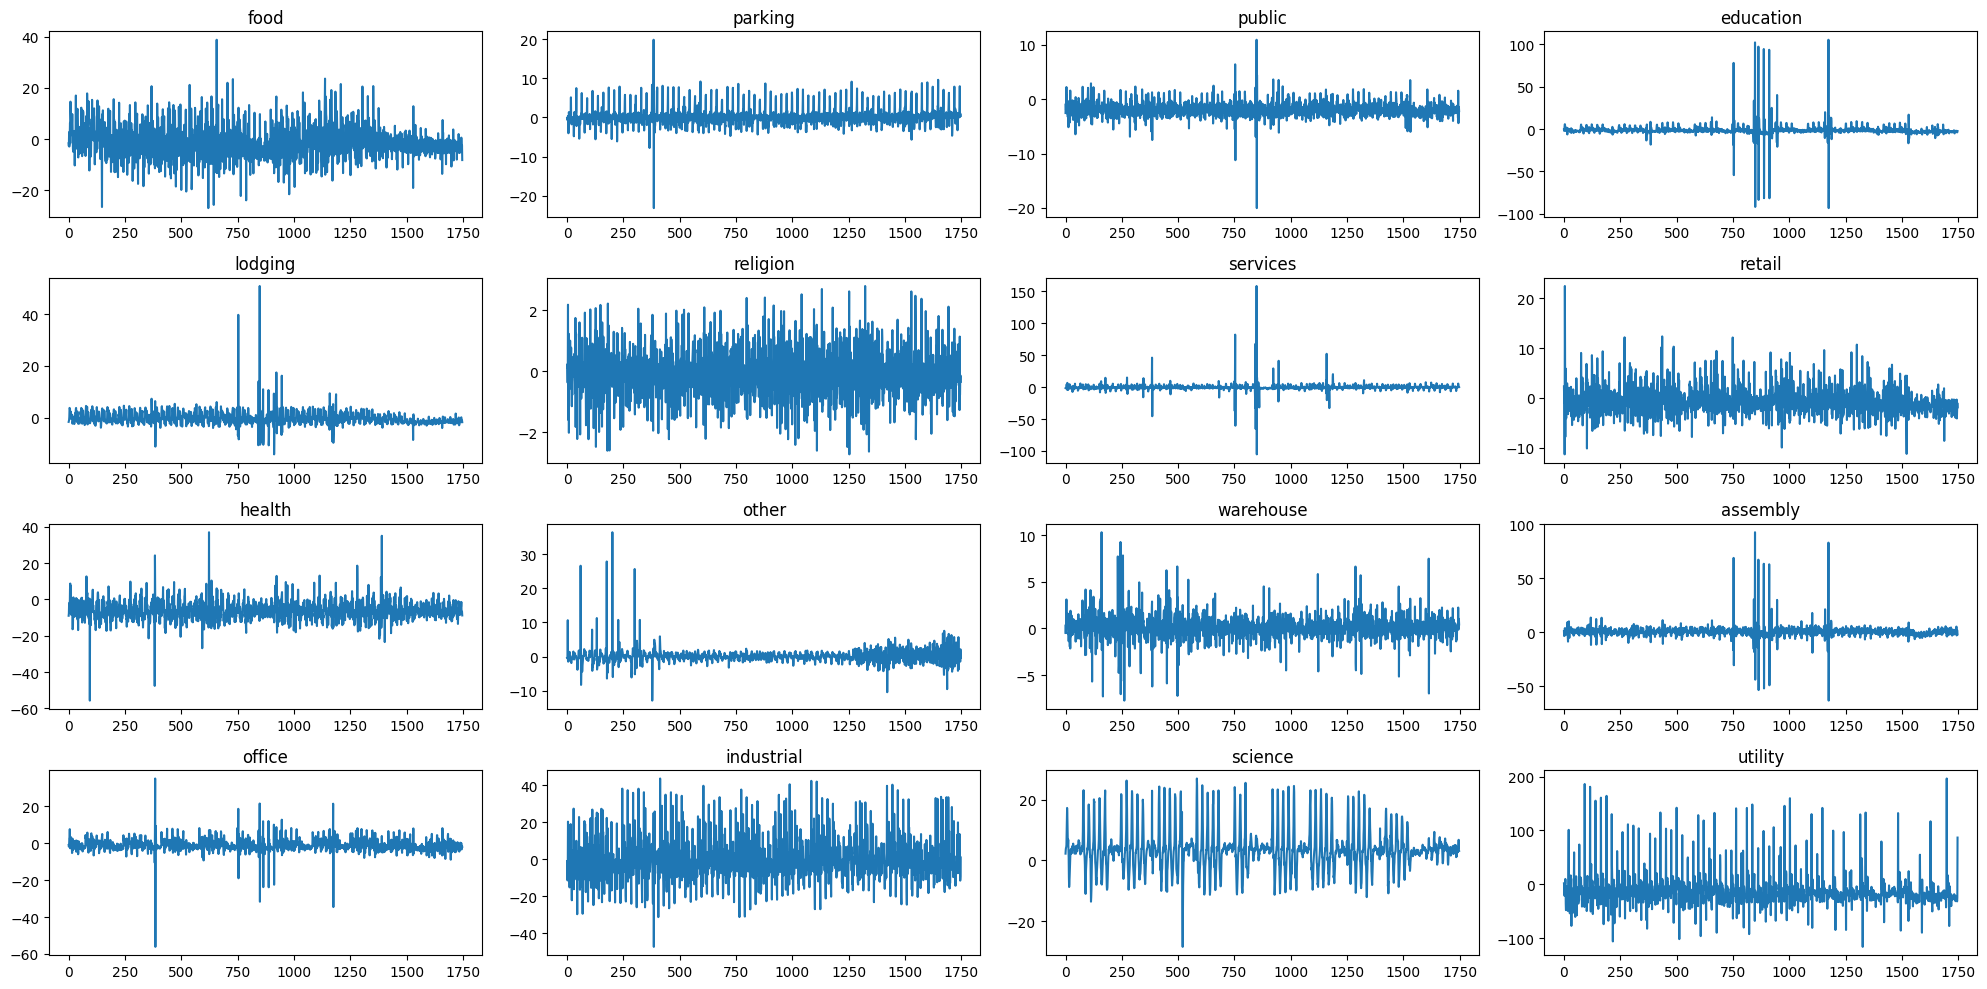

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense  # <-- changed to GRU

# helper to turn a series into (X, Y) windows
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for j in range(len(dataset) - look_back - 1):
        X.append(dataset[j:(j + look_back), 0])
        Y.append(dataset[j + look_back, 0])
    return np.array(X), np.array(Y)

# pre-built plot grid for displaying
fig, ax = plt.subplots(4, 4, figsize=(20, 10))

buildings = list(set([name[1] for name in names]))
models = {}

look_back = 4
n_obs = sub_dfs[buildings[0]].shape[0]

for i in range(16):
    b = buildings[i]
    # 1) aggregate
    avg_series = sub_dfs[b].mean(axis=1).values.reshape(-1, 1)

    # 2) split indexes for 80/10/10
    train_end = int(n_obs * 0.8)
    val_end   = train_end + int(n_obs * 0.1)

    train_raw = avg_series[:train_end]
    val_raw   = avg_series[train_end:val_end]
    test_raw  = avg_series[val_end:]

    # 3) scale using TRAIN only
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_raw)
    val_scaled   = scaler.transform(val_raw)
    test_scaled  = scaler.transform(test_raw)

    # 4) to supervised
    X_train, Y_train = create_dataset(train_scaled, look_back)
    X_val,   Y_val   = create_dataset(val_scaled,   look_back)
    X_test,  Y_test  = create_dataset(test_scaled,  look_back)

    # 5) reshape for GRU
    X_train = X_train.reshape(-1, look_back, 1)
    X_val   = X_val.reshape(-1,   look_back, 1)
    X_test  = X_test.reshape(-1,  look_back, 1)

    # 6) grid-search on val MSE over units only
    best_loss = np.inf
    best_u    = None
    for units in [10, 25]:
        tmp = Sequential([
            GRU(units=units, input_shape=(look_back, 1)),  # <-- GRU layer
            Dense(1)
        ])
        tmp.compile(loss='mse', optimizer='adam')
        tmp.fit(X_train, Y_train, epochs=3, batch_size=1, verbose=0)
        val_pred = tmp.predict(X_val)
        mse = np.mean((val_pred.flatten() - Y_val)**2)
        if mse < best_loss:
            best_loss = mse
            best_u    = units

    print(f"Building {b!r}: best units={best_u}, val MSE={best_loss:.4f}")

    # 7) build final model with best_u, retrain on train+val
    model = Sequential([
        GRU(units=best_u, input_shape=(look_back, 1)),  # <-- GRU here too
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')

    X_trainval = np.vstack([X_train, X_val])
    Y_trainval = np.hstack([Y_train, Y_val])
    model.fit(X_trainval, Y_trainval, epochs=3, batch_size=1, verbose=1)
    models[b] = model

    # 8) predict & inverse-scale on TEST
    test_pred = model.predict(X_test)
    test_pred = scaler.inverse_transform(test_pred)
    Y_test_inv = scaler.inverse_transform(Y_test.reshape(1, -1)).flatten()

    # 9) plot residuals
    ax[i//4, i%4].plot(Y_test_inv - test_pred.flatten())
    ax[i//4, i%4].set_title(b)

plt.tight_layout()


In [27]:
# ── Metrics Summary Cell ──────────────────────────────────────────────────────

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
    explained_variance_score
)
import numpy as np

# Re‐define these if you haven’t kept them in memory:
look_back = 4
n_obs     = sub_dfs[buildings[0]].shape[0]
train_end = int(n_obs * 0.8)
val_end   = train_end + int(n_obs * 0.1)

def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

def compute_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    ev   = explained_variance_score(y_true, y_pred)
    return mae, rmse, mape, r2, ev

all_true = []
all_pred = []

print("\nPer-building test metrics:")
for b in buildings[:16]:
    # 1) rebuild scaler on train‐only
    series = sub_dfs[b].mean(axis=1).values.reshape(-1,1)
    scaler = MinMaxScaler((0,1))
    scaler.fit(series[:train_end])

    # 2) prepare test set
    test_raw    = series[val_end:]
    test_scaled = scaler.transform(test_raw)
    X_test, Y_test = create_dataset(test_scaled, look_back)
    X_test = X_test.reshape(-1, look_back, 1)

    # 3) predict & invert
    y_pred = scaler.inverse_transform(models[b].predict(X_test)).flatten()
    y_true = scaler.inverse_transform(Y_test.reshape(-1,1)).flatten()

    # 4) compute & print
    mae, rmse, mape, r2, ev = compute_metrics(y_true, y_pred)
    print(f" {b:20s} → MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.2%}, R²: {r2:.3f}, ExplVar: {ev:.3f}")

    all_true.extend(y_true)
    all_pred.extend(y_pred)

# 5) overall
all_true = np.array(all_true)
all_pred = np.array(all_pred)
o_mae, o_rmse, o_mape, o_r2, o_ev = compute_metrics(all_true, all_pred)

print("\nOverall test metrics:")
print(f" MAE: {o_mae:.3f}, RMSE: {o_rmse:.3f}, MAPE: {o_mape:.2%}, R²: {o_r2:.3f}, ExplVar: {o_ev:.3f}")



Per-building test metrics:
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 food                 → MAE: 4.815, RMSE: 6.372, MAPE: 6.51%, R²: 0.910, ExplVar: 0.911
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 parking              → MAE: 1.238, RMSE: 2.110, MAPE: 2.55%, R²: 0.887, ExplVar: 0.889
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 public               → MAE: 1.979, RMSE: 2.279, MAPE: 2.57%, R²: 0.929, ExplVar: 0.974
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 education            → MAE: 3.129, RMSE: 8.237, MAPE: 1.81%, R²: 0.875, ExplVar: 0.877
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 lodging              → MAE: 1.778, RMSE: 2.782, MAPE: 2.17%, R²: 0.953, ExplVar: 0.954
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 religion             → MAE: 0.587, RMSE: 0.786, MAPE: 16.74%, R²: 0.471, ExplVar: 0.474
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 services             → MAE: 2.165, RMSE: 6.835, MAPE: 2.42%, R²: 0.838, ExplVar: 0.839
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 retail               → MAE: 2.033, RMSE: 2